In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from rich.progress import track
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import os

/var/folders/s2/61s_f7nd2hs98dcwv1fvd5m40000gn/T/ipykernel_13076/3955425762.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"Epoch {epoch+1}, loss = {loss.item()}, classification prob = {torch.max(F.softmax(output))}")


Epoch 10, loss = 5435894272.0, classification prob = 0.4841642677783966
Epoch 20, loss = 5222534656.0, classification prob = 0.48416420817375183


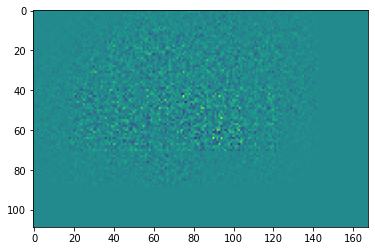

In [99]:
# construct CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 20, 5)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        self.fc1 = nn.Linear(3960, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn(self.conv1(x))))
        res1 = x.view(x.shape[0], -1).clone()
        x = self.pool(F.relu(self.bn(self.conv2(x))))
        res2 = x.view(x.shape[0], -1).clone()
        x = self.pool2(F.relu(self.bn(self.conv3(x))))
        res3 = x.view(x.shape[0], -1).clone()
        x = F.relu(self.bn(self.conv4(x)))
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, res2, res3), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet()
model.load_state_dict(torch.load('torch_model.pth'))

input = torch.ones((32,1,109,168))
input.requires_grad=True

lr = 0.1
lmbda = 0.01

for epoch in range(20):
    output = model(input)
    target = torch.Tensor([[0,0,0,1,0,0,0,0,0,0] for _ in range(32)])
    loss = F.cross_entropy(output, target) + lmbda*torch.square(torch.norm(input))
    loss.backward()
    if (epoch + 1) % 10 == 0: 
        print(f"Epoch {epoch+1}, loss = {loss.item()}, classification prob = {torch.max(F.softmax(output))}")
        print_input = input.detach().numpy()
    if (epoch + 1) % 20 == 0: 
        plt.imshow(np.squeeze(print_input[0,0,:,:]))
        plt.show()
    
    with torch.no_grad():
        input = input - lr * input.grad
        input.requires_grad = True